## Import functions and constants

In [1]:
import warnings
from main_code import *

Supress specific warnings

In [2]:
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")
warnings.filterwarnings("ignore", message="Spectres: new_wavs contains values outside")

## Load in, blur and resample the data

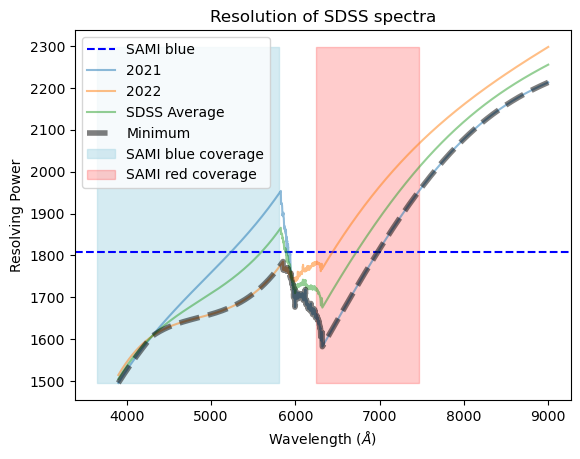

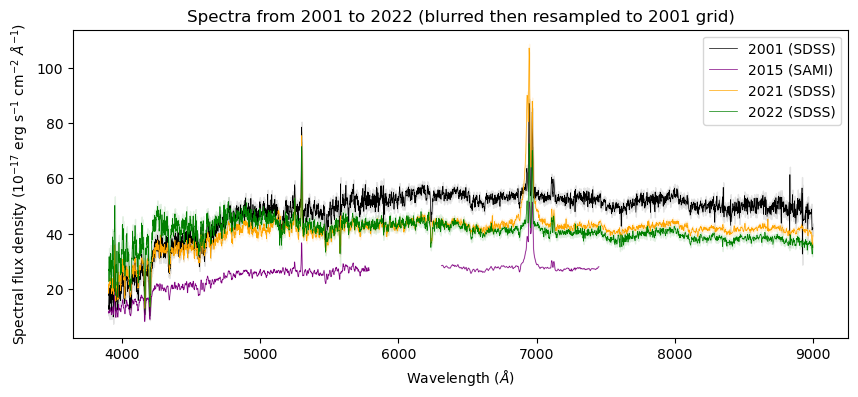

In [3]:
zoom = (6900, 7000)

data = data_reading.get_adjusted_data(
    blur_before_resampling=True,
    # as_is_xlim=zoom,
    # clipped_xlim=zoom,
    # blurred_xlim=zoom,
    # resampled_xlim=zoom,
    # resampled_and_blurred_xlim=zoom,
    plot_res_coverage=True,
    plot_errors=True
)
unadjusted_data = data_reading.get_adjusted_data(return_as_is=True)

(
    (ua_lam01, ua_flux01, ua_err01),
    (ua_lam15_blue, ua_flux15_blue, ua_err15_blue),
    (ua_lam15_red, ua_flux15_red, ua_err15_red),
    (ua_lam21, ua_flux21, ua_err21),
    (ua_lam22, ua_flux22, ua_err22)
) = unadjusted_data

lam, (data01, data15, data21, data22) = data
flux01, err01 = data01
flux15, err15 = data15
flux21, err21 = data21
flux22, err22 = data22

## Qualitatively inspecting a sensible region of Balmer emission to ignore

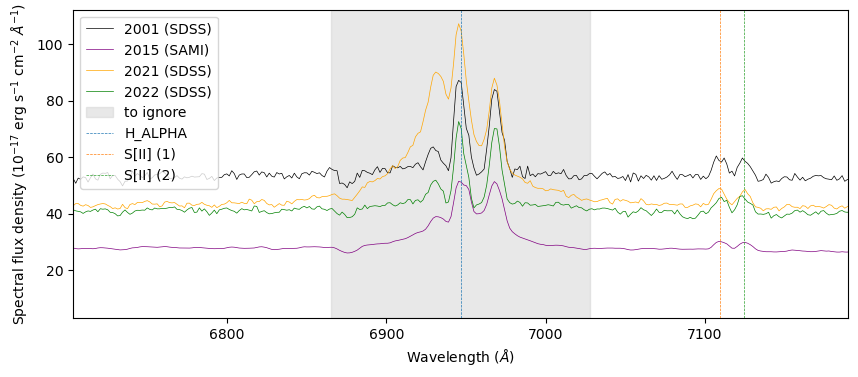

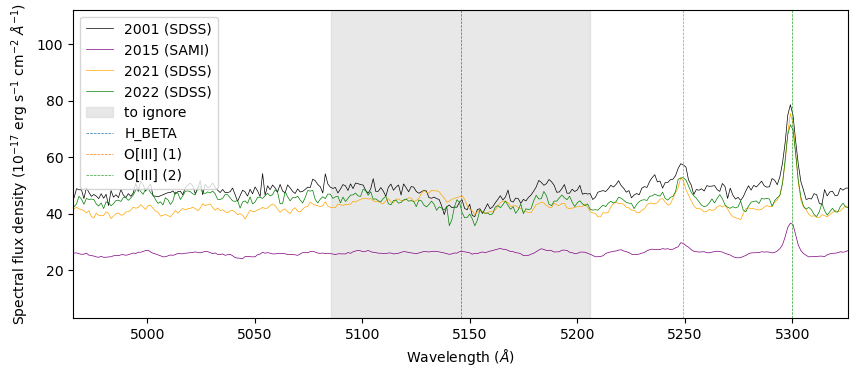

Width of wavelengths to ignore around Hα: 162.20 Å
Width of wavelengths to ignore around Hβ: 120.15 Å


In [4]:
plot_width_vel = VEL_PLOT_WIDTH
selection_width_vel = VEL_TO_IGNORE_WIDTH

h_alpha_lam_bounds = helpers.get_lam_bounds(H_ALPHA, selection_width_vel, width_is_vel=True)
h_beta_lam_bounds = helpers.get_lam_bounds(H_BETA, selection_width_vel, width_is_vel=True)
# plot_width_ang = 400

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01,
    flux15,
    flux21,
    flux22,
    plot_errors=False,
    ions = {"H_ALPHA": H_ALPHA, "S[II] (1)": SII_1, "S[II] (2)": SII_2},
    x_bounds = helpers.get_lam_bounds(H_ALPHA, plot_width_vel, width_is_vel=True),
    fill_between_bounds=h_alpha_lam_bounds,
    fill_between_label="to ignore",
    legend_loc="upper left"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01,
    flux15,
    flux21,
    flux22,
    plot_errors=False,
    ions = {"H_BETA": H_BETA, "O[III] (1)": OIII_1, "O[III] (2)": OIII_2},
    x_bounds = helpers.get_lam_bounds(H_BETA, plot_width_vel, width_is_vel=True),
    fill_between_bounds=h_beta_lam_bounds,
    fill_between_label="to ignore",
    legend_loc="upper left"
)

print(f"Width of wavelengths to ignore around Hα: {h_alpha_lam_bounds[1] - h_alpha_lam_bounds[0]:.2f} Å")
print(f"Width of wavelengths to ignore around Hβ: {h_beta_lam_bounds[1] - h_beta_lam_bounds[0]:.2f} Å")

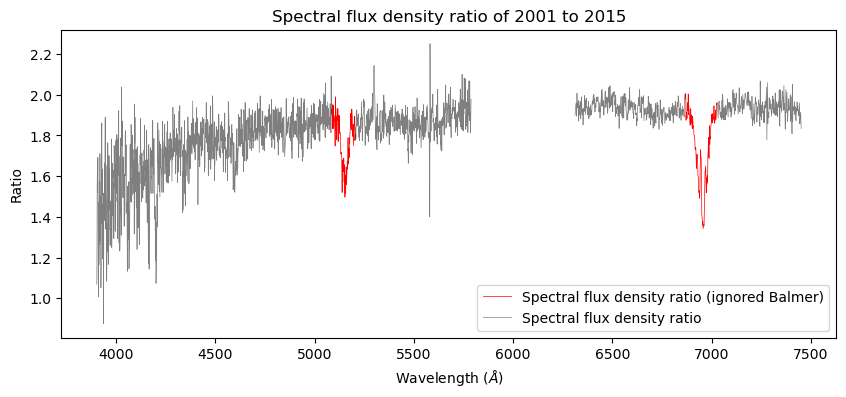

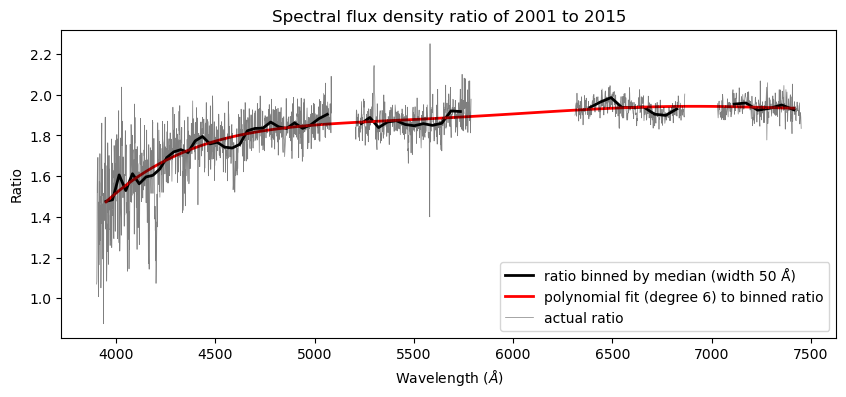

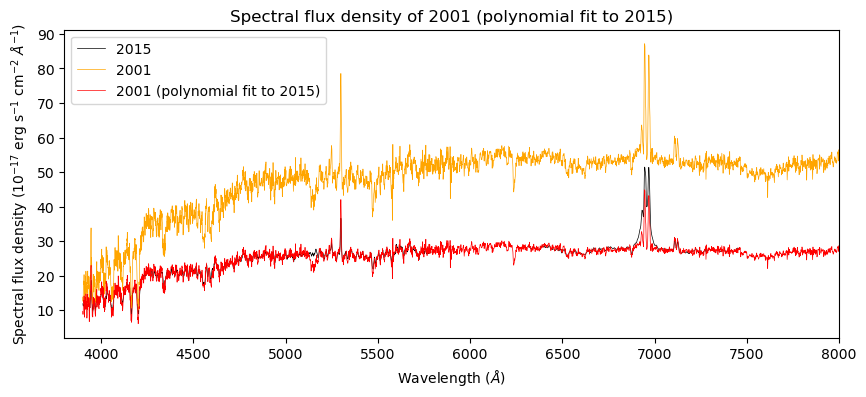

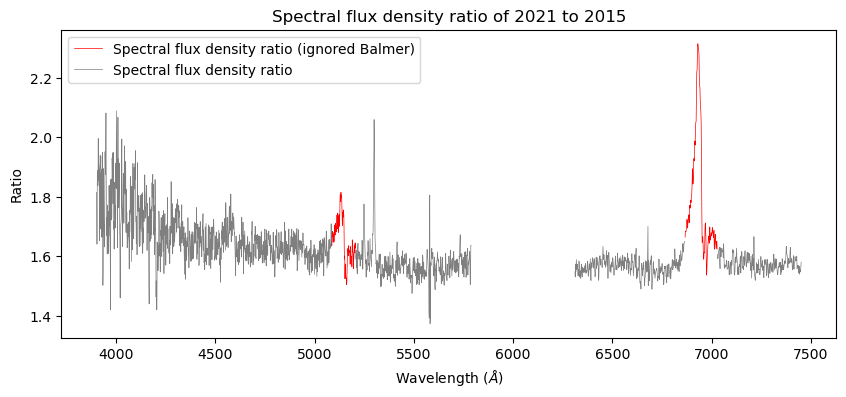

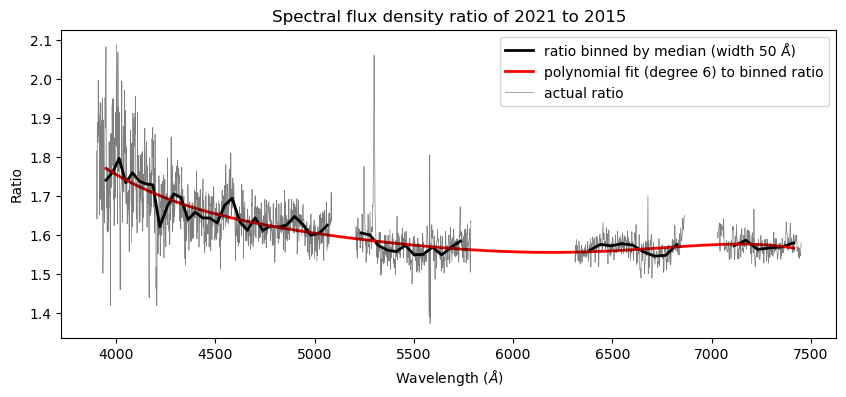

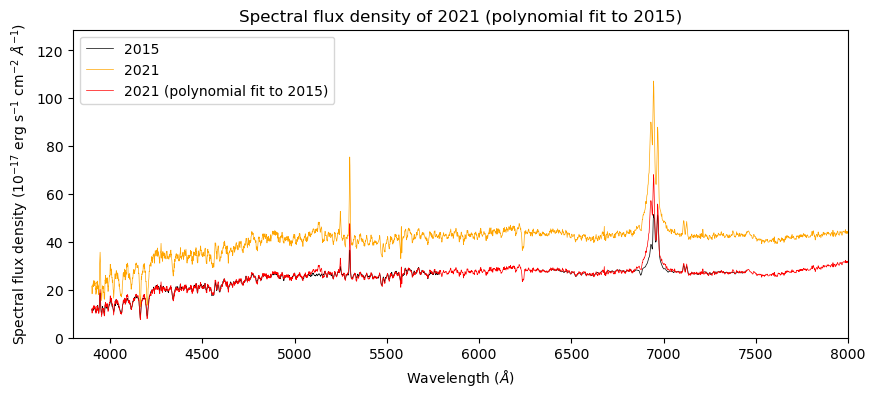

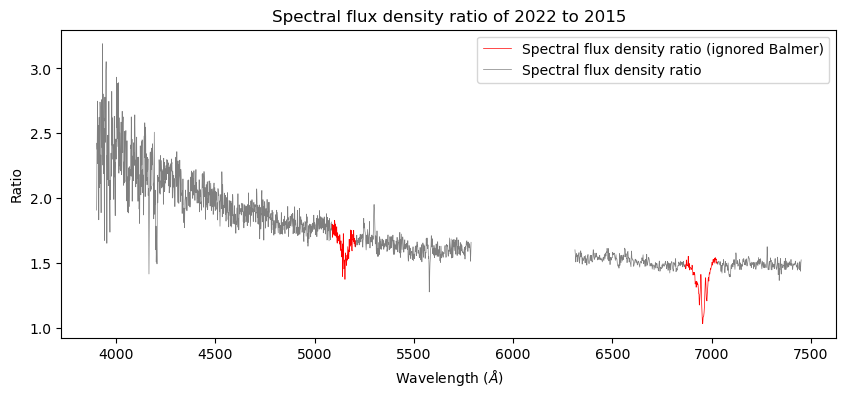

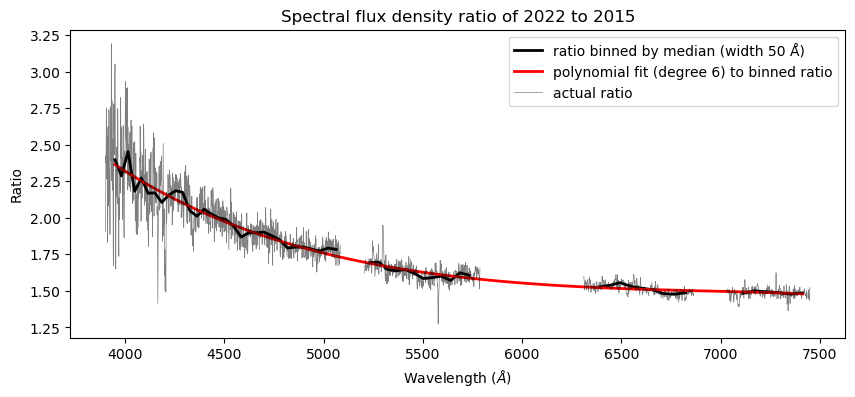

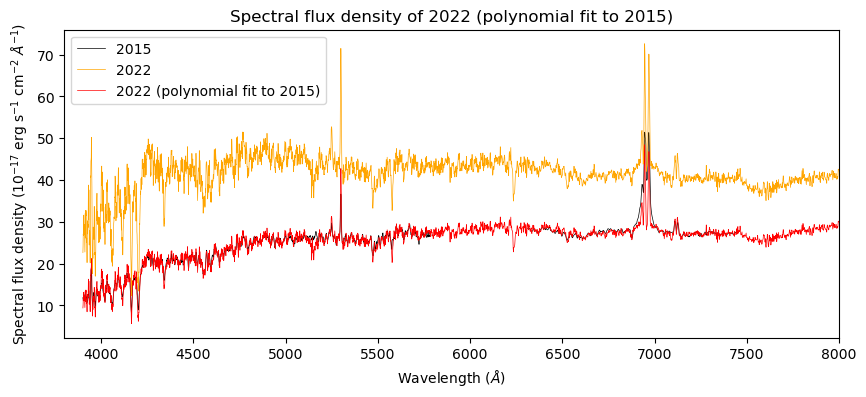

In [5]:
_, adjusted_01_flux_15, adjusted_01_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2001)
# same as adjusted_15_flux_15, adjusted_15_err_15 = flux15, err15
_, adjusted_15_flux_15, adjusted_15_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2015)
#
_, adjusted_21_flux_15, adjusted_21_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2021)
_, adjusted_22_flux_15, adjusted_22_err_15 = polynomial_fit.apply_poly_fit(data=data, year_to_adjust=2022)

## Check polynomial fitted spectra and uncertainties around H-$\alpha$

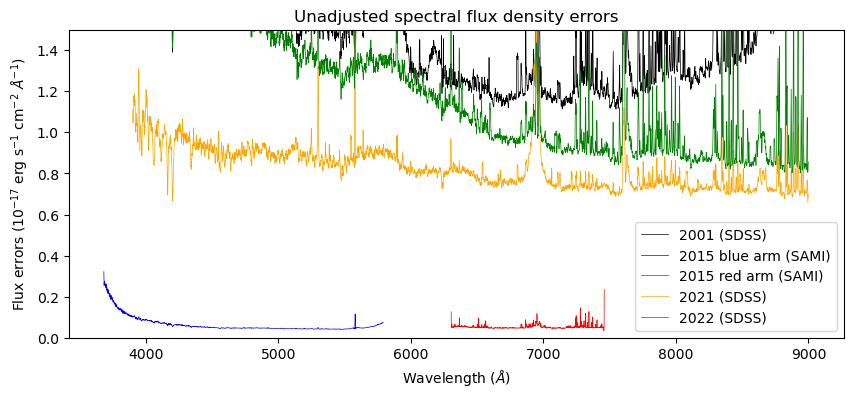

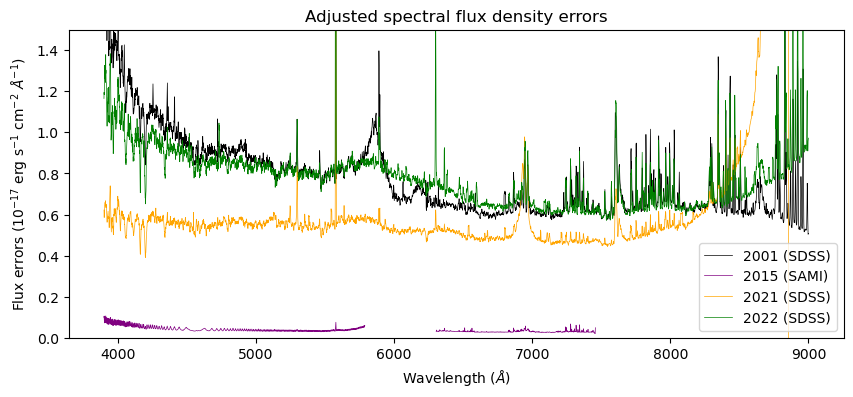

In [6]:
plotting.plot_spectra(
    ua_lam01, (ua_lam15_blue, ua_lam15_red), ua_lam21, ua_lam22,
    flux01=ua_err01,
    flux15=(ua_err15_blue, ua_err15_red),
    flux21=ua_err21,
    flux22=ua_err22,
    # x_bounds=h_alpha_lam_bounds,
    y_bounds=(0, 1.5),
    y_axis_label=f"Flux errors ({SFD_UNITS})",
    title=f"Unadjusted spectral flux density errors"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    flux01=adjusted_01_err_15,
    flux15=adjusted_15_err_15,
    flux21=adjusted_21_err_15,
    flux22=adjusted_22_err_15,
    # x_bounds=h_alpha_lam_bounds,
    y_bounds=(0, 1.5),
    y_axis_label=f"Flux errors ({SFD_UNITS})",
    title=f"Adjusted spectral flux density errors"
)


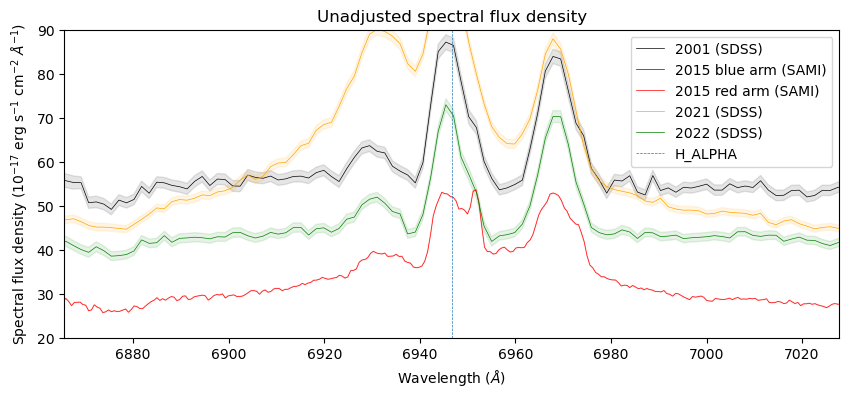

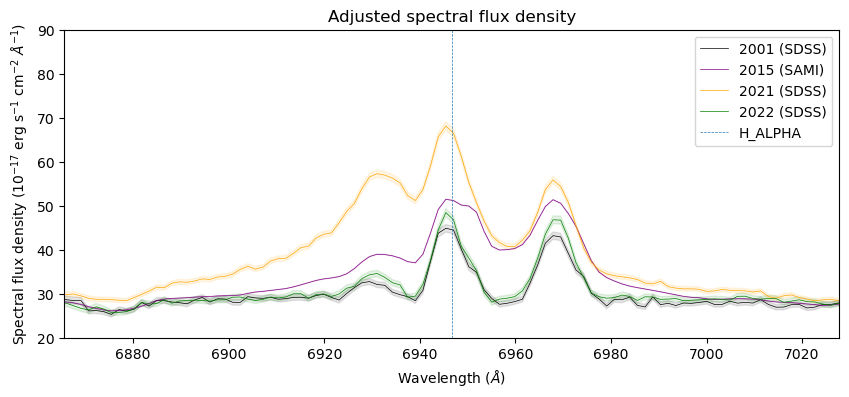

In [7]:
y_bounds = (20, 90)

plotting.plot_spectra(
    ua_lam01, (ua_lam15_blue, ua_lam15_red), ua_lam21, ua_lam22,
    ua_flux01,
    (ua_flux15_blue, ua_flux15_red),
    ua_flux21,
    ua_flux22,
    plot_errors=True,
    flux01_err=ua_err01,
    flux15_err=(ua_err15_blue, ua_err15_red),
    flux21_err=ua_err21,
    flux22_err=ua_err22,
    x_bounds=h_alpha_lam_bounds,
    y_bounds=y_bounds,
    ions = {"H_ALPHA": H_ALPHA},
    title=f"Unadjusted spectral flux density"
)

plotting.plot_spectra(
    lam, lam, lam, lam,
    adjusted_01_flux_15,
    adjusted_15_flux_15,
    adjusted_21_flux_15,
    adjusted_22_flux_15,
    plot_errors=True,
    flux01_err=adjusted_01_err_15,
    flux15_err=adjusted_15_err_15,
    flux21_err=adjusted_21_err_15,
    flux22_err=adjusted_22_err_15,
    x_bounds=h_alpha_lam_bounds,
    y_bounds=y_bounds,
    ions = {"H_ALPHA": H_ALPHA},
    title=f"Adjusted spectral flux density"
)

## Difference spectra

In [8]:
(diff_15, diff_21, diff_22), (diff_15_err, diff_21_err, diff_22_err) = difference.get_diff_spectra()

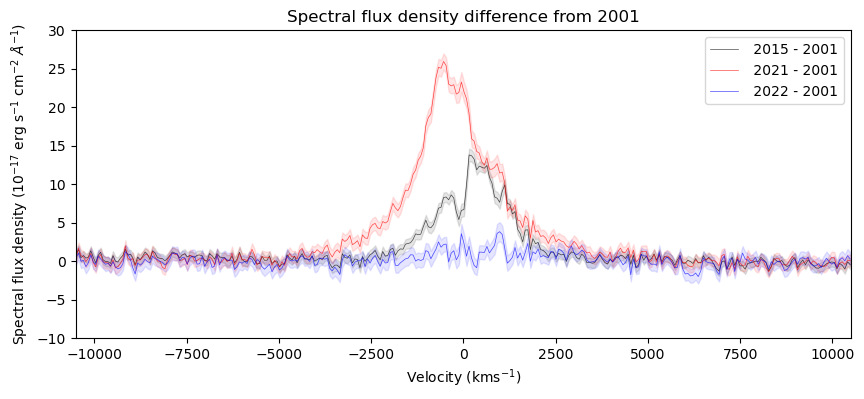

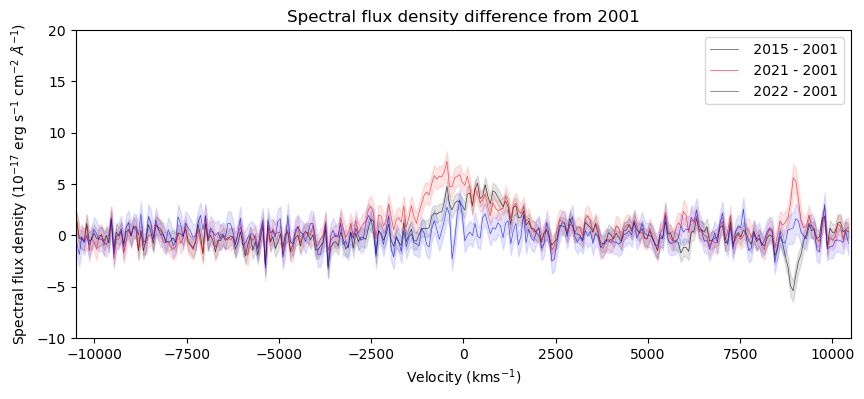

In [9]:
plotting.plot_diff_spectra(
    lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    plot_labels=None,
    # use_ang_x_axis=True,
    plot_centres=H_ALPHA
)
plotting.plot_diff_spectra(
    lam,
    diff_15=diff_15,
    diff_21=diff_21,
    diff_22=diff_22,
    diff_15_err=diff_15_err,
    diff_21_err=diff_21_err,
    diff_22_err=diff_22_err,
    plot_labels=None,
    # use_ang_x_axis=True,
    plot_centres=H_BETA
)

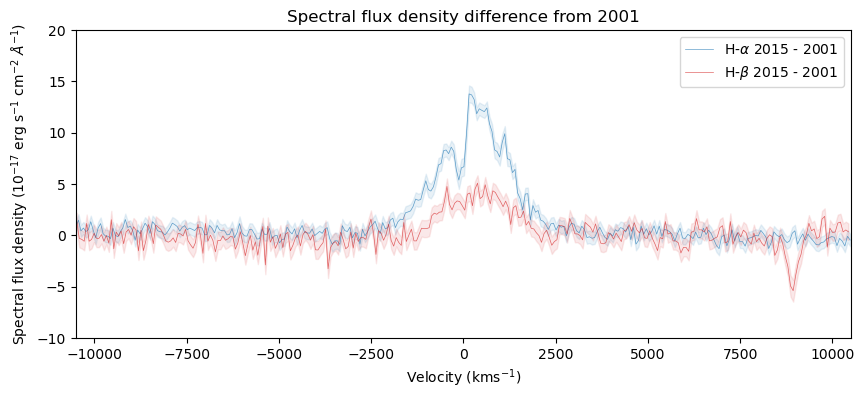

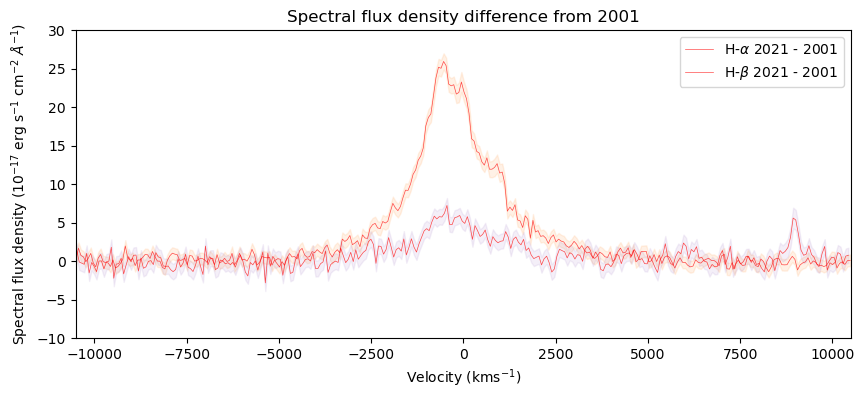

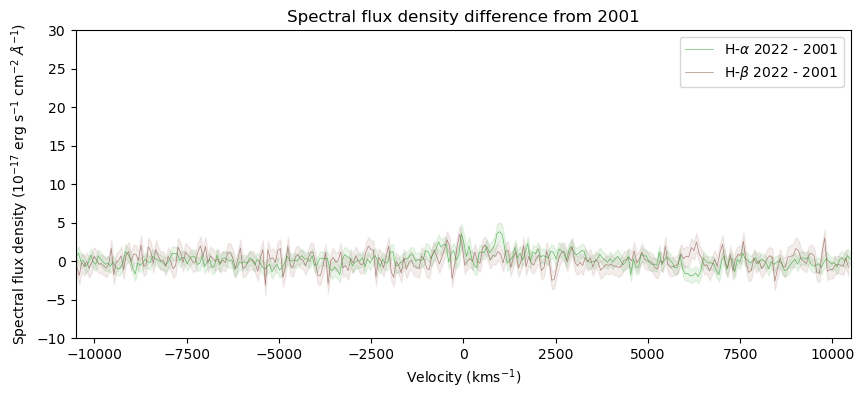

In [10]:
plotting.plot_diff_spectra(
    lam,
    diff_15=diff_15,
    diff_15_err=diff_15_err,
    plot_y_bounds=(-10, 20)
)
plotting.plot_diff_spectra(
    lam,
    diff_21=diff_21,
    diff_21_err=diff_21_err
)
plotting.plot_diff_spectra(
    lam,
    diff_22=diff_22,
    diff_22_err=diff_22_err
)

{'-1 sigma above (Hβ) mean': np.float64(-0.47752444111778725), '0 sigma above (Hβ) mean': np.float64(1.2136937806326207), '1 sigma above (Hβ) mean': np.float64(2.9049120023830284), '2 sigma above (Hβ) mean': np.float64(4.596130224133437), '3 sigma above (Hβ) mean': np.float64(6.287348445883845)}
{'-1 sigma above (Hβ) mean': np.float64(0.39616857233652913), '0 sigma above (Hβ) mean': np.float64(2.2641837777512435), '1 sigma above (Hβ) mean': np.float64(4.132198983165958), '2 sigma above (Hβ) mean': np.float64(6.000214188580673), '3 sigma above (Hβ) mean': np.float64(7.868229393995387)}
{'-1 sigma above (Hβ) mean': np.float64(-0.9198550456287065), '0 sigma above (Hβ) mean': np.float64(0.21016954361092094), '1 sigma above (Hβ) mean': np.float64(1.3401941328505484), '2 sigma above (Hβ) mean': np.float64(2.4702187220901757), '3 sigma above (Hβ) mean': np.float64(3.600243311329803)}


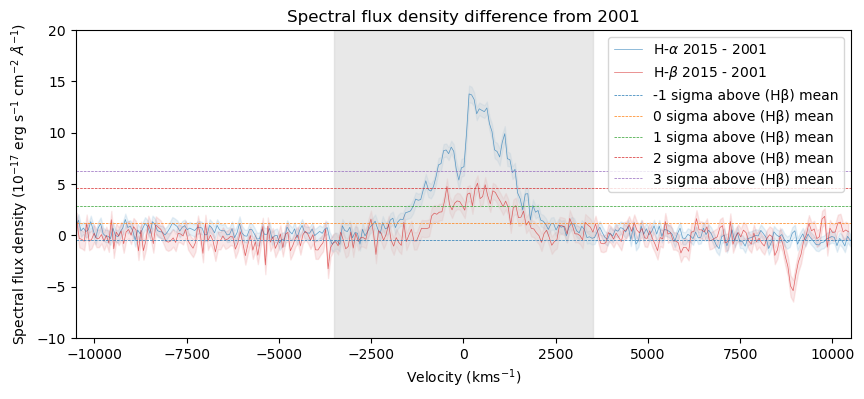

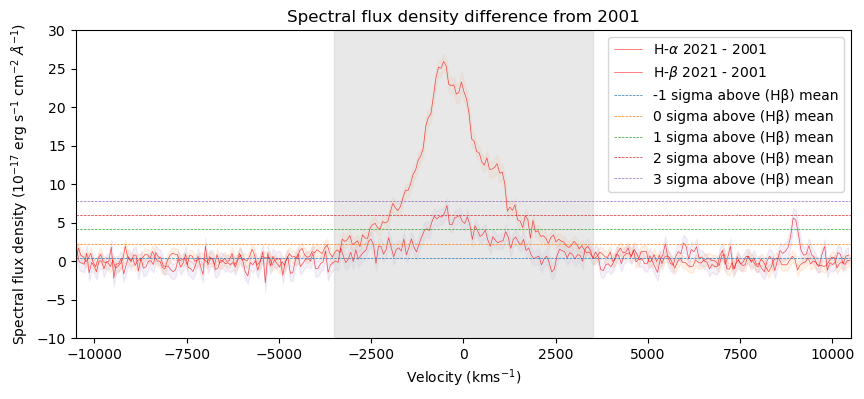

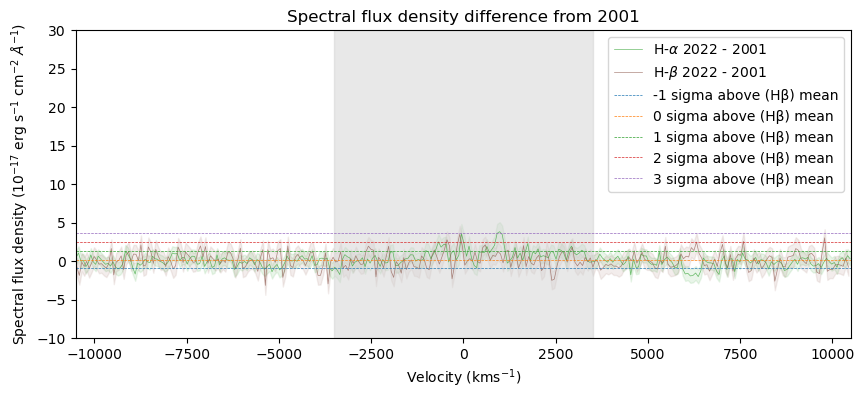

In [11]:
hlines_15 = {}
hlines_21 = {}
hlines_22 = {}

h_alpha_mask = get_vel_lam_mask(lam, VEL_TO_IGNORE_WIDTH, H_ALPHA)
h_beta_mask = get_vel_lam_mask(lam, VEL_TO_IGNORE_WIDTH, H_BETA)

for i in range(-1, 4):
    # height_15_alpha = np.nanmean(diff_15[h_alpha_mask]) + i * np.nanstd(diff_15[h_alpha_mask])
    # height_21_alpha = np.nanmean(diff_21[h_alpha_mask]) + i * np.nanstd(diff_21[h_alpha_mask])
    # height_22_alpha = np.nanmean(diff_22[h_alpha_mask]) + i * np.nanstd(diff_22[h_alpha_mask])
    # hlines_15[f"{i} sigma above (Hα) mean"] = height_15_alpha
    # hlines_21[f"{i} sigma above (Hα) mean"] = height_21_alpha
    # hlines_22[f"{i} sigma above (Hα) mean"] = height_22_alpha
    height_15_beta = np.nanmean(diff_15[h_beta_mask]) + i * np.nanstd(diff_15[h_beta_mask])
    height_21_beta = np.nanmean(diff_21[h_beta_mask]) + i * np.nanstd(diff_21[h_beta_mask])
    height_22_beta = np.nanmean(diff_22[h_beta_mask]) + i * np.nanstd(diff_22[h_beta_mask])
    hlines_15[f"{i} sigma above (Hβ) mean"] = height_15_beta
    hlines_21[f"{i} sigma above (Hβ) mean"] = height_21_beta
    hlines_22[f"{i} sigma above (Hβ) mean"] = height_22_beta

print(hlines_15)
print(hlines_21)
print(hlines_22)

plotting.plot_diff_spectra(
    lam,
    diff_15=diff_15,
    diff_15_err=diff_15_err,
    plot_y_bounds=(-10, 20),
    hlines=hlines_15,
    fill_between_bounds=(-VEL_TO_IGNORE_WIDTH/2, VEL_TO_IGNORE_WIDTH/2)
)
plotting.plot_diff_spectra(
    lam,
    diff_21=diff_21,
    diff_21_err=diff_21_err,
    hlines=hlines_21,
    fill_between_bounds=(-VEL_TO_IGNORE_WIDTH/2, VEL_TO_IGNORE_WIDTH/2)
)
plotting.plot_diff_spectra(
    lam,
    diff_22=diff_22,
    diff_22_err=diff_22_err,
    hlines=hlines_22,
    fill_between_bounds=(-VEL_TO_IGNORE_WIDTH/2, VEL_TO_IGNORE_WIDTH/2)
)

## Flux integration

Gaussian fitting


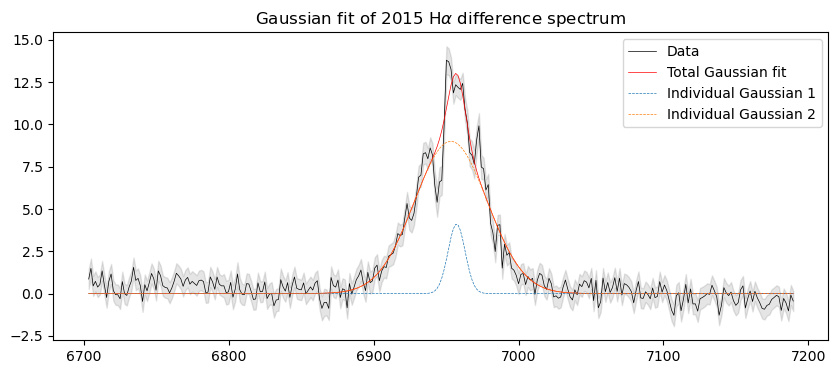

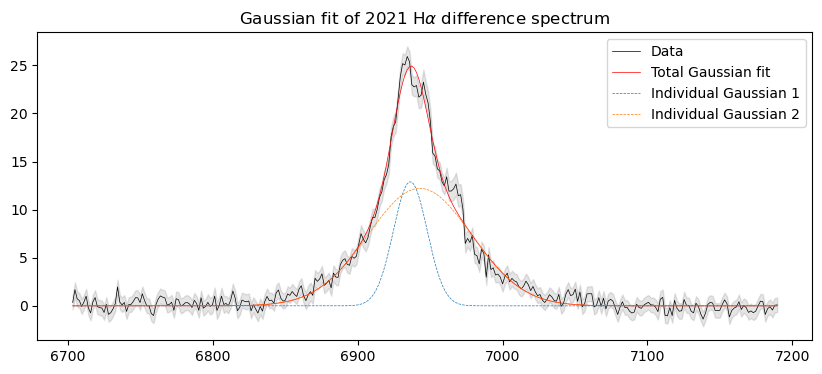

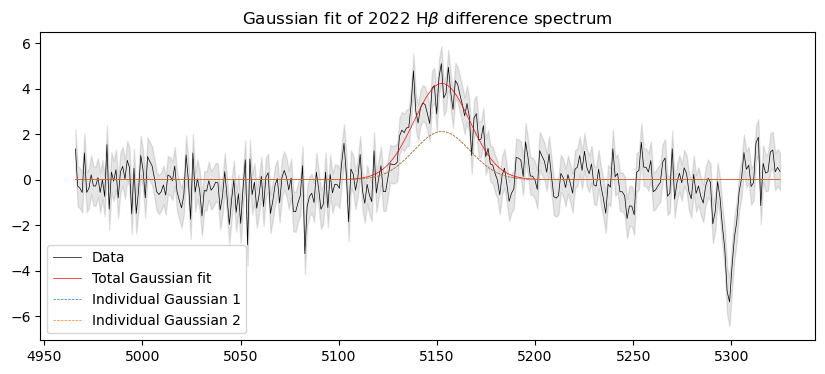

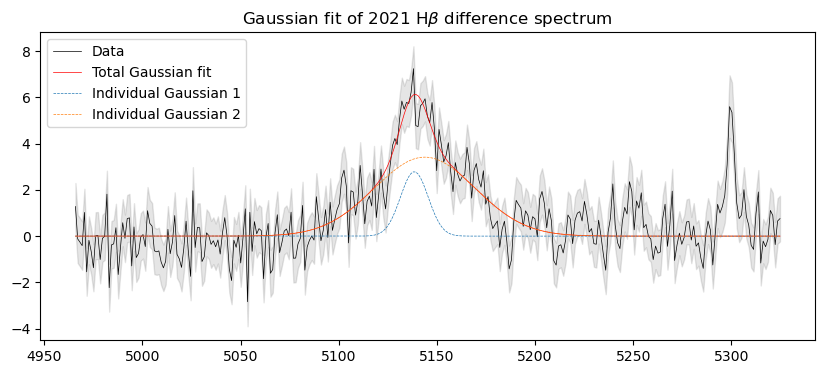

In [14]:
n = 2

gaussian_fitting.fit_gaussians(
    x=lam,
    y=diff_15,
    mask_lam_centre=H_ALPHA,
    num_of_gaussians=n,
    plot_fit=True,
    plot_params={
        "plot_y_errs": True,
        "y_errs": diff_15_err,
        "title": r"Gaussian fit of 2015 H$\alpha$ difference spectrum"
    }
);
gaussian_fitting.fit_gaussians(
    x=lam,
    y=diff_21,
    mask_lam_centre=H_ALPHA,
    num_of_gaussians=n,
    plot_fit=True,
    plot_params={
        "plot_y_errs": True,
        "y_errs": diff_21_err,
        "title": r"Gaussian fit of 2021 H$\alpha$ difference spectrum"
    }
);
gaussian_fitting.fit_gaussians(
    x=lam,
    y=diff_15,
    mask_lam_centre=H_BETA,
    num_of_gaussians=n,
    plot_fit=True,
    plot_params={
        "plot_y_errs": True,
        "y_errs": diff_15_err,
        "title": r"Gaussian fit of 2022 H$\beta$ difference spectrum"
    }
);
gaussian_fitting.fit_gaussians(
    x=lam,
    y=diff_21,
    mask_lam_centre=H_BETA,
    num_of_gaussians=n,
    plot_fit=True,
    plot_params={
        "plot_y_errs": True,
        "y_errs": diff_21_err,
        "title": r"Gaussian fit of 2021 H$\beta$ difference spectrum"
    }
);


Comparison with photometry values

Balmer decrements

Balck hole mass calculation